In [30]:
using DifferentialEquations
using Plots
using LaTeXStrings
pgfplotsx()

Plots.PGFPlotsXBackend()

Consider the simple reaction:

\begin{align}
    A + * &\longleftrightarrow A_*\\
    A_*   &\longleftrightarrow B + *\\
\end{align}

Both are elementary steps that occur in the liquid phase, and we will consider it in a few different solvent environments.

In [31]:
function batch(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k20, K10, K20, Ns, NS = PAR

    NA     = u[:,1]
    NB     = u[:,2]

    NT     = NA + NB .+ NS
    
    XA   = NA./NT
    XB   = NB./NT
    XS   = NS./NT
    
    #For A in solvent
    A12A = MAR[1]

    #For As in solvent
    A12As = MAR[2]
    
    #For B in solvent
    A12B = MAR[3]
    
    #For Transition State 1 in solvent
    A12TS1 = MAR[4]
    
    #For Transition State 2 in solvent
    A12TS2 = MAR[5]

    gammaA  = exp.(XS.^2*A12A)
    gammaAs = exp.(XS.^2*A12As)
    gammaB  = exp.(XS.^2*A12B)

    gammaTS1 = exp.(XS.^2*A12TS1)
    gammaTS2 = exp.(XS.^2*A12TS2)
    
    thetastar = 1 ./(1 .+ K10*gammaA./gammaAs.*XA)
    thetaA   = K10*gammaA./gammaAs.*XA.*thetastar

    z2 = 1/K20*gammaB./gammaAs.*XB.*thetastar./thetaA
    r2 = k20*gammaAs./gammaTS2.*thetaA.*(1 .- z2)
   
    RA  = -r2[1]
    RB  =       r2[1]
    
    du[1] = RA*Ns
    du[2] = RB*Ns
    return du, r2, z2, thetastar, thetaA
end

batch (generic function with 1 method)

In [32]:
K    = 1
Ns   = 0.001
k20  = 0.01
V    = 1
NTOT = 100

NA0  = 0.1
NAs0 = 0.0
NB0  = 0.0

NS   = NTOT - NA0 - NB0

var0     = [NA0 NB0]
span     = (0.0, 10000000);

In [33]:
#Solvate transition state relative to reactants
MARSET1 = zeros(5,3)
MARSET1[:,1] = [0.0, 0.0, 0.0, 0.0, 0.0] #no solvation
MARSET1[:,2] = [0.0, 2.0, 0.0, 0.0, 0.0] #destabilize TS1
MARSET1[:,3] = [0.0, -2.0, 0.0, 0.0, 0.0] #stabilize TS1
K10SET       = [10, 1000, 10000, 100000]#10 .^range(1, stop = 4, length = 4)
K20SET       = K./K10SET

labels = Matrix{String}(undef, 1, length(K10SET))

for m = 1:length(K10SET)
    labels[m] = string("K1 = ", K10SET[m])
end

tfine  = 10 .^(range(-8.0, stop = log10(maximum(span)), length = 1000))
Xout   = zeros(length(tfine), size(K10SET, 1), 3)
r2out  = zeros(length(tfine), size(K10SET, 1), 3)
z2out  = zeros(length(tfine), size(K10SET, 1), 3)
cov    = zeros(length(tfine), size(K10SET, 1), 3)

for i = 1:3
    for j = 1:length(K10SET)
        p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k20, K10SET[j], K20SET[j], Ns, NS])
        prob = ODEProblem(batch, var0, span, p0)
        sol  = solve(prob, Rodas5(), abstol = 1e-16, reltol = 1e-16)
        solf = sol(tfine)
        NA   = solf[1,:]
        NB   = solf[2,:]
        NT   = NA + NB .+ NS
    
        dut, rt2, zt2, thetastart, thetaAt = batch([0., 0.], [NA NB], p0, tfine)

        ext  = NB/NA0
        cov[:, j, i]  = thetaAt
        Xout[:, j, i]  = ext
        r2out[:, j, i] = rt2
        z2out[:, j, i] = zt2
    end
end

pertX1   = Xout[:,:,2]./Xout[:,:,1]
pertX2   = Xout[:,:,3]./Xout[:,:,1]
pertC1   = cov[:,:,2]./cov[:,:,1]
pertC2   = cov[:,:,3]./cov[:,:,1];

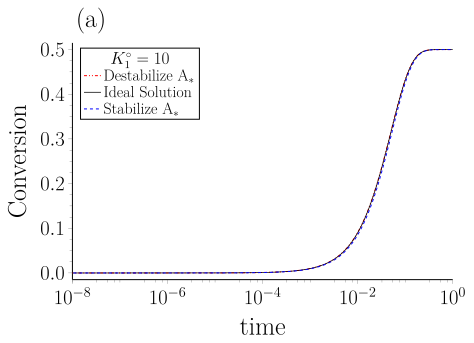

In [49]:
plt1 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    #yscale = :log10,
    #ylim = (1e-1, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legend  = :topleft,
    legendtitle = L"\ \ \ \ K_1^\circ = 10",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 26
)


plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,1,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")
plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,1,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt1 = plot!(plt1, tfine/maximum(tfine), Xout[:,1,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")

display(plt1)
savefig(plt1, "CS31.pdf")

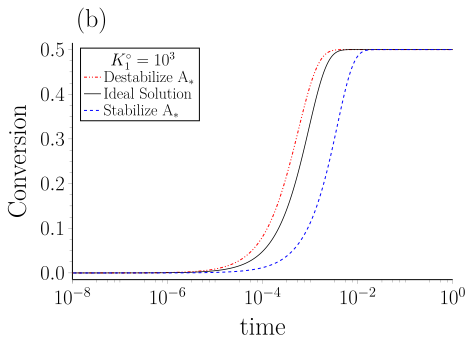

In [50]:
plt2 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    #yscale = :log10,
    #ylim = (1e-1, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legend  = :topleft,
    legendtitle = L"\ \ \ \ K_1^\circ = 10^3",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 26
)


plt2 = plot!(plt2, tfine/maximum(tfine), Xout[:,2,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")
plt2 = plot!(plt2, tfine/maximum(tfine), Xout[:,2,1], ls = :solid,      lc = :black, lw = 0.75,  label = L"\textrm{Ideal Solution}")
plt2 = plot!(plt2, tfine/maximum(tfine), Xout[:,2,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")

display(plt2)
savefig(plt2, "CS32.pdf")

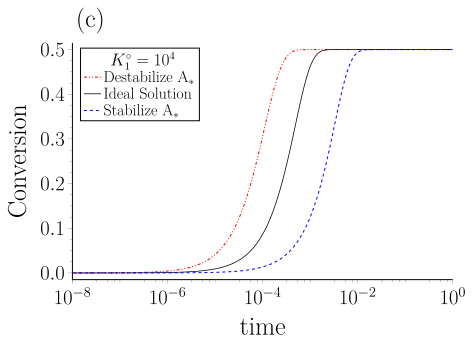

In [51]:
plt3 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    #yscale = :log10,
    #ylim = (1e-1, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legend  = :topleft,
    legendtitle = L"\ \ \ \ K_1^\circ = 10^4",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 26
)


plt3 = plot!(plt3, tfine/maximum(tfine), Xout[:,3,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")
plt3 = plot!(plt3, tfine/maximum(tfine), Xout[:,3,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt3 = plot!(plt3, tfine/maximum(tfine), Xout[:,3,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")

display(plt3)
savefig(plt3, "CS33.pdf")

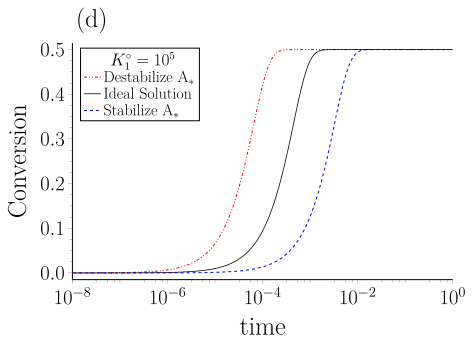

In [52]:
plt4 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    #yscale = :log10,
    #ylim = (1e-1, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = "Conversion", 
    fontfamily = "Times Roman",
    legend  = :topleft,
    legendtitle = L"\ \ \ \ K_1^\circ = 10^5",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(d)",
    titlelocation = :left,
    titlefontsize = 26
)

plt4 = plot!(plt4, tfine/maximum(tfine), Xout[:,4,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")
plt4 = plot!(plt4, tfine/maximum(tfine), Xout[:,4,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt4 = plot!(plt4, tfine/maximum(tfine), Xout[:,4,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")

display(plt4)
savefig(plt4, "CS34.pdf")

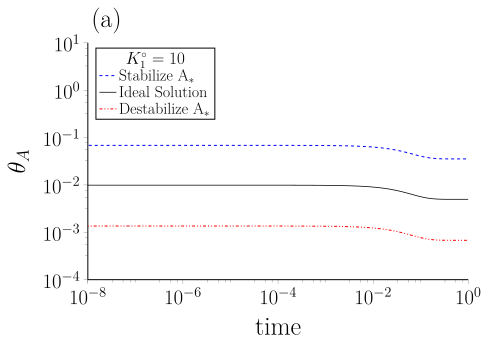

In [38]:
plt5 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    yscale = :log10,
    ylim = (1e-4, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = L"\theta_{A}", 
    fontfamily = "Times Roman",
    legend  = :topleft,
    legendtitle = L"\ \ \ \ K_1^\circ = 10",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 26
)

plt5 = plot!(plt5, tfine/maximum(tfine), cov[:,1,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")
plt5 = plot!(plt5, tfine/maximum(tfine), cov[:,1,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt5 = plot!(plt5, tfine/maximum(tfine), cov[:,1,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")

display(plt5)
savefig(plt5, "CS35.pdf")

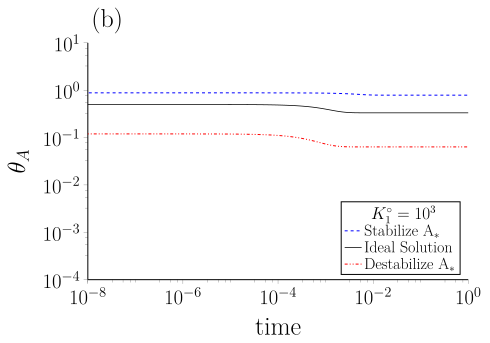

In [39]:
plt6 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    yscale = :log10,
    ylim = (1e-4, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = L"\theta_{A}", 
    fontfamily = "Times Roman",
    legend  = :bottomright,
    legendtitle = L"\ \ \ \ K_1^\circ = 10^3",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 26
)

plt6 = plot!(plt6, tfine/maximum(tfine), cov[:,2,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")
plt6 = plot!(plt6, tfine/maximum(tfine), cov[:,2,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt6 = plot!(plt6, tfine/maximum(tfine), cov[:,2,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")

display(plt6)
savefig(plt6, "CS36.pdf")

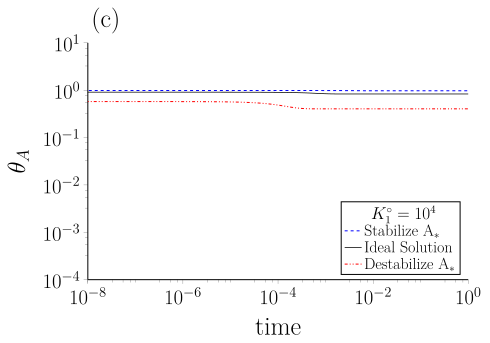

In [40]:
plt7 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    yscale = :log10,
    ylim = (1e-4, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = L"\theta_{A}", 
    fontfamily = "Times Roman",
    legend  = :bottomright,
    legendtitle = L"\ \ \ \ K_1^\circ = 10^4",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 26
)

plt7 = plot!(plt7, tfine/maximum(tfine), cov[:,3,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")
plt7 = plot!(plt7, tfine/maximum(tfine), cov[:,3,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt7 = plot!(plt7, tfine/maximum(tfine), cov[:,3,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")

display(plt7)
savefig(plt7, "CS37.pdf")

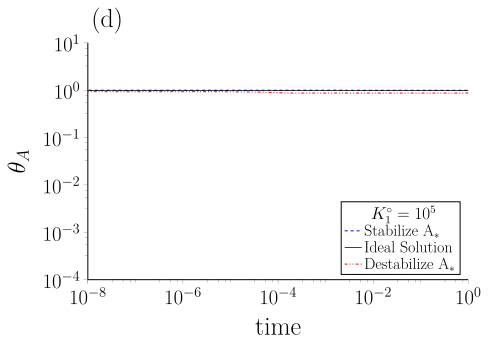

In [41]:
plt8 = plot(
    xscale  = :log10,
    xlim    = (1e-8, 1.0),
    xminorticks = 4,
    yscale = :log10,
    ylim = (1e-4, 1e1),
    yminorticks = 4,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 26,
    yguidefontsize = 26,
    tickfontsize = 20,
    xlabel  = "time", 
    ylabel  = L"\theta_{A}", 
    fontfamily = "Times Roman",
    legend  = :bottomright,
    legendtitle = L"\ \ \ \ K_1^\circ = 10^5",
    legendfontsize = 16,
    legendfonthalign = :left,
    title = "(d)",
    titlelocation = :left,
    titlefontsize = 26
)

plt8 = plot!(plt8, tfine/maximum(tfine), cov[:,4,3], ls = :dash,       lc = :blue,  lw = 1.00, label = L"\textrm{Stabilize A}_*")
plt8 = plot!(plt8, tfine/maximum(tfine), cov[:,4,1], ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{Ideal Solution}")
plt8 = plot!(plt8, tfine/maximum(tfine), cov[:,4,2], ls = :dashdotdot, lc = :red,   lw = 1.00, label = L"\textrm{Destabilize A}_*")

display(plt8)
savefig(plt8, "CS38.pdf")

In [42]:
function coverage(p)
    MARs = p["MARs"]
    PAR  = p["PAR"]

    K10, NA, NB, NS = PAR

    NT     = NA + NB + NS
    
    XA   = NA/NT
    XB   = NB/NT
    XS   = NS/NT
    
    #For A in solvent
    A12A = 0.0

    #For As in solvent
    A12As = MARs
    
    #For B in solvent
    A12B = 0.0

    gammaA  = exp(XS^2*A12A)
    gammaAs = exp(XS^2*A12As)
    #print(log(gammaA), ' ', log(gammaAs), '\n')
        
    thetastar = 1/(1 + K10*gammaA/gammaAs*XA)
    thetaA    = K10*gammaA/gammaAs*XA*thetastar
    activityAs = gammaAs*thetaA 
    
    return thetaA, activityAs
end

coverage (generic function with 1 method)

In [43]:
#Calculate Coverages
MARs = [-3, -2, -1, 0, 1, 2, 3]
K10SET  = 10 .^range(-2, stop = 8, length = 500)
K20SET  = K./K10SET

cov    = zeros(size(K10SET, 1), length(MARs))
act    = zeros(size(K10SET, 1), length(MARs))

for i = 1:length(MARs)
    for j = 1:length(K10SET)
        p0   = Dict("MARs" => MARs[i], "PAR" => [K10SET[j], NA0, NB0, NS])
        ct, at = coverage(p0)
        cov[j,i] = ct
        act[j,i] = at
    end
end

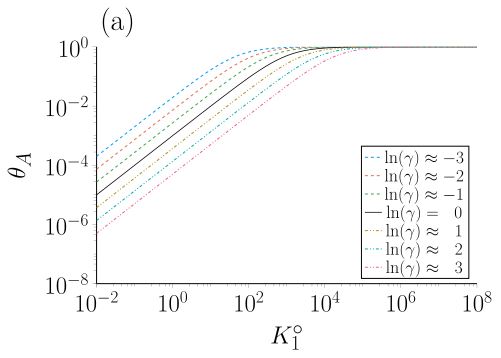

In [55]:
plt9 = plot(
    xscale  = :log10,
    xlim    = (1e-2, 1e8),
    #xticks  = 10. .^range(-2, stop = 7, step = 1),
    xminorticks = 5,
    yscale = :log10,
    ylim = (1e-8, 1e0),
    yminorticks = 5,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 30,
    yguidefontsize = 30,
    tickfontsize = 24,
    xlabel  = L"K_1^\circ", 
    ylabel  = L"\theta_A", 
    fontfamily = "Times Roman",
    legend  = :bottomright,
    legendfontsize = 18,
    title = "(a)",
    titlelocation = :left,
    titlefontsize = 30
)

plt9 = plot!(plt9, K10SET, cov[:,1:3], ls = :dash,       lc = :auto,  lw = 1.00, labels = [L"\textrm{ln}(\gamma) \approx -3" L"\textrm{ln}(\gamma) \approx -2" L"\textrm{ln}(\gamma) \approx -1"])
plt9 = plot!(plt9, K10SET, cov[:,4],   ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{ln}(\gamma) = \ \ 0")
plt9 = plot!(plt9, K10SET, cov[:,5:7], ls = :dashdotdot, lc = :auto,  lw = 1.00, labels = [L"\textrm{ln}(\gamma) \approx \ \ 1" L"\textrm{ln}(\gamma) \approx \ \ 2" L"\textrm{ln}(\gamma) \approx \ \ 3" ])
display(plt9)
savefig(plt9, "CS39.pdf")

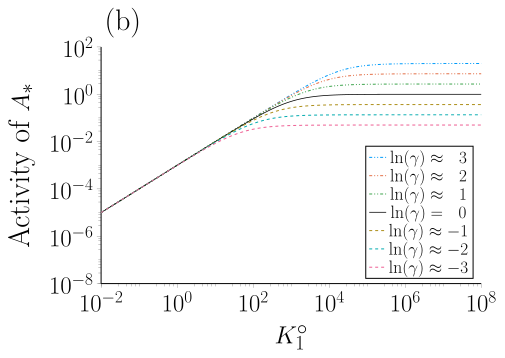

In [58]:
plt10 = plot(
    xscale  = :log10,
    xlim    = (1e-2, 1e8),
    #xticks  = 10. .^range(-2, stop = 7, step = 1),
    xminorticks = 5,
    yscale = :log10,
    ylim = (1e-8, 1e2),
    yminorticks = 5,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 30,
    yguidefontsize = 30,
    tickfontsize = 24,
    xlabel  = L"K_1^\circ", 
    ylabel  = L"\textrm{Activity of} \ A_*", 
    fontfamily = "Times Roman",
    legend  = :bottomright,
    legendfontsize = 18,
    title = "(b)",
    titlelocation = :left,
    titlefontsize = 30
)

plt10 = plot!(plt10, K10SET, reverse(act[:,5:7], dims = 2), ls = :dashdotdot, lc = :auto,  lw = 1.00, labels = [L"\textrm{ln}(\gamma) \approx \ \ 3" L"\textrm{ln}(\gamma) \approx \ \ 2" L"\textrm{ln}(\gamma) \approx \ \ 1" ])
plt10 = plot!(plt10, K10SET, act[:,4],                      ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{ln}(\gamma) = \ \ 0")
plt10 = plot!(plt10, K10SET, reverse(act[:,1:3], dims = 2), ls = :dash,       lc = :auto,  lw = 1.00, labels = [L"\textrm{ln}(\gamma) \approx -1" L"\textrm{ln}(\gamma) \approx -2" L"\textrm{ln}(\gamma) \approx -3"])
display(plt10)
savefig(plt10, "CS310.pdf")

In [46]:
function rate(p)
    MARs = p["MARs"]
    PAR  = p["PAR"]

    k20, K10, K20, NA, NB, NS = PAR

    NT     = NA + NB + NS
    
    XA   = NA/NT
    XB   = NB/NT
    XS   = NS/NT
    
    #For A in solvent
    A12A = 0.0

    #For As in solvent
    A12As = MARs
    
    #For B in solvent
    A12B = 0.0
    
    #For TS1 in solvent
    A12TS1 = 0.0
    
    #For TS2 in solvent
    A12TS2 = 0.0

    gammaA  = exp(XS^2*A12A)
    gammaAs = exp(XS^2*A12As)
    #print(log(gammaAs))
    gammaB  = exp(XS^2*A12B)
    gammaTS1 = exp(XS^2*A12TS1)
    gammaTS2 = exp(XS^2*A12TS2)
        
    thetastar = 1/(1 + K10*gammaA/gammaAs*XA)
    thetaA    = K10*gammaA/gammaAs*XA*thetastar
    activityAs = gammaAs*thetaA 
    
    r2 = k20*gammaAs/gammaTS2*thetaA
    
    return thetaA, activityAs, r2
end

rate (generic function with 1 method)

In [47]:
#Calculate Rates and Coverages
MARs = [-3, -2, -1, 0, 1, 2, 3]
K10SET  = 10 .^range(-2, stop = 8, length = 500)
K20SET  = K./K10SET

labels = Matrix{String}(undef, 1, length(K10SET))

# for m = 1:length(MARs)
#     labels[m] = string("log10gamma = ", MARs[m])
# end

cov    = zeros(size(K10SET, 1), length(MARs))
act    = zeros(size(K10SET, 1), length(MARs))
rat    = zeros(size(K10SET, 1), length(MARs))

for i = 1:length(MARs)
    for j = 1:length(K10SET)
        p0   = Dict("MARs" => MARs[i], "PAR" => [k20, K10SET[j], K20SET[j], NA0, NB0, NS])
        ct, at, rt = rate(p0)
        cov[j,i] = ct
        act[j,i] = at
        rat[j,i] = rt
    end
end

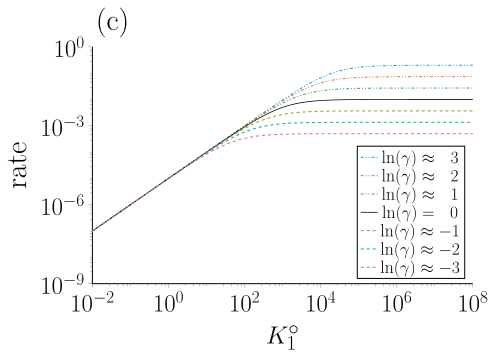

In [59]:
plt11 = plot(
    xscale  = :log10,
    xlim    = (1e-2, 1e8),
    #xticks  = 10. .^range(-2, stop = 7, step = 1),
    xminorticks = 5,
    yscale = :log10,
    ylim = (1e-9, 1e0),
    yminorticks = 5,
    tick_direction = :out, 
    grid = :off, 
    xguidefontsize = 30,
    yguidefontsize = 30,
    tickfontsize = 24,
    xlabel  = L"K_1^\circ", 
    ylabel  = "rate", 
    fontfamily = "Times Roman",
    legend  = :bottomright,
    legendfontsize = 18,
    title = "(c)",
    titlelocation = :left,
    titlefontsize = 30
)

plt11 = plot!(plt11, K10SET, reverse(rat[:,5:7], dims = 2), ls = :dashdotdot, lc = :auto,  lw = 1.00, labels = [L"\textrm{ln}(\gamma) \approx \ \ 3" L"\textrm{ln}(\gamma) \approx \ \ 2" L"\textrm{ln}(\gamma) \approx \ \ 1" ])
plt11 = plot!(plt11, K10SET, rat[:,4],                      ls = :solid,      lc = :black, lw = 0.75, label = L"\textrm{ln}(\gamma) = \ \ 0")
plt11 = plot!(plt11, K10SET, reverse(rat[:,1:3], dims = 2), ls = :dash,       lc = :auto,  lw = 1.00, labels = [L"\textrm{ln}(\gamma) \approx -1" L"\textrm{ln}(\gamma) \approx -2" L"\textrm{ln}(\gamma) \approx -3"])

display(plt11)
savefig(plt11, "CS311.pdf")